# Design Single Country Nat Cat Bonds

In [1]:
#import general packages
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

#import climada stuff
from climada.entity.impact_funcs import trop_cyclone, impact_func_set
from climada.util.api_client import Client
from climada.engine import ImpactCalc

%load_ext autoreload
%autoreload 2
import haz_storm as hst
import exposures as ex
import grider as grd
import impact as cimp
import bound_prot_dam as bpd
import prem_ibrd as prib
import haz_int_grd as hig
import set_nominal as snom
import functions as fct
import calc_premium as cp
import simulate_bond as sb
import alt_pay_opt as apo
import grider as grd
import n_fct_t_rl_thm_ll as bond_create
client = Client()

c:\Users\kaibe\miniforge3\envs\climada_env\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


## Perform natural hazard simulation 
### Define variables for cat bonds

In [2]:
#choose country
country = 882

#number of simulated years
r = 10000

#define maximum and minimum return periods to be covered
lower_share = 0.045
upper_rp = 250

target_sharpe = 0.5
rf_rate = 0.0

## Check Buffer Size

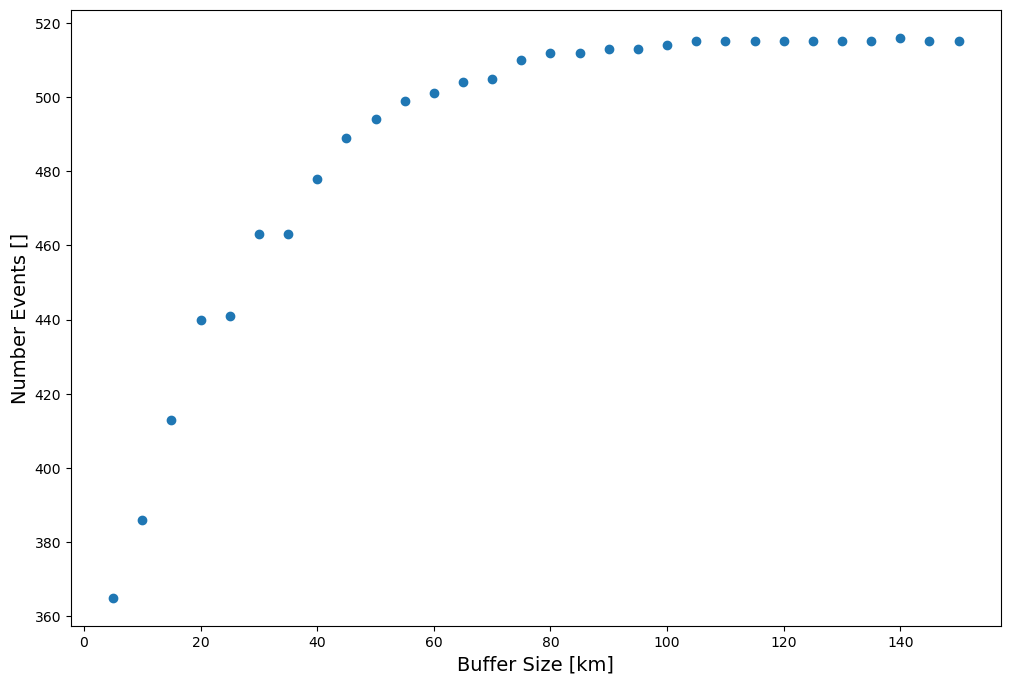

In [3]:
events_buffer = pd.read_excel("C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/Samoa/events_vs_buffer_882.xlsx")
plt.figure(figsize=(12, 8))  # Width=12 inches, Height=8 inches
plt.scatter(events_buffer['Buffer Distance (km)'], events_buffer['Number Events'])
plt.xlabel('Buffer Size [km]', fontsize=14)
plt.ylabel('Number Events []', fontsize=14)
plt.show()

## Check Basis Risk

<function matplotlib.pyplot.show(close=None, block=None)>

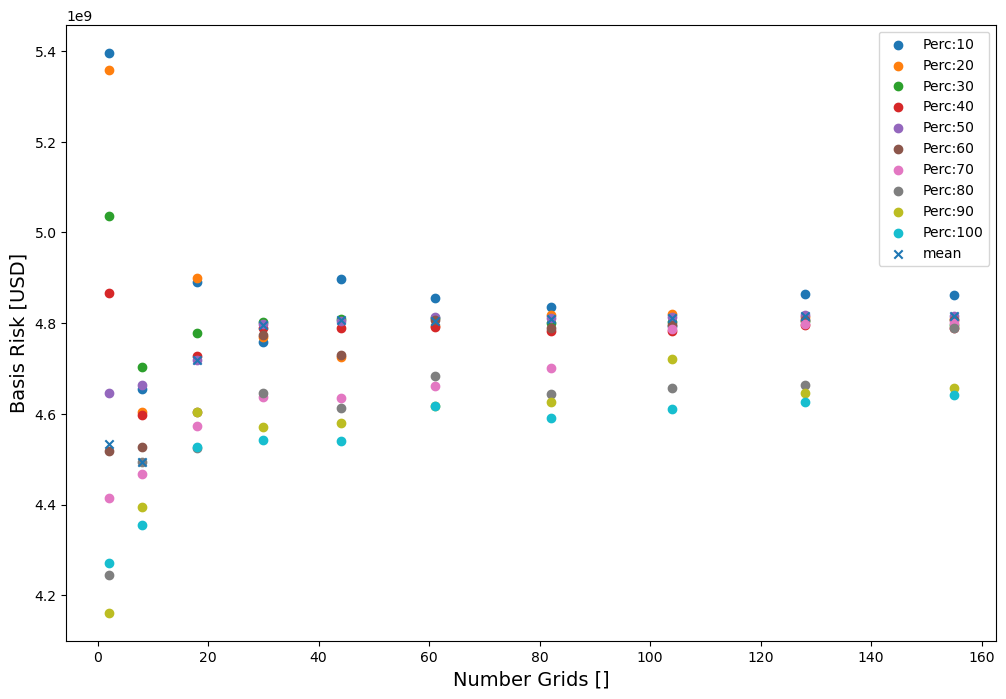

In [4]:
br_grids_opt = pd.read_excel("C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/Samoa/basis_risk_grids_882.xlsx")
plt.figure(figsize=(12, 8))  # Width=12 inches, Height=8 inches
plt.scatter(br_grids_opt['Count grids'], br_grids_opt[10], label='Perc:10')
plt.scatter(br_grids_opt['Count grids'], br_grids_opt[20], label='Perc:20')
plt.scatter(br_grids_opt['Count grids'], br_grids_opt[30], label='Perc:30')
plt.scatter(br_grids_opt['Count grids'], br_grids_opt[40], label='Perc:40')
plt.scatter(br_grids_opt['Count grids'], br_grids_opt[50], label='Perc:50')
plt.scatter(br_grids_opt['Count grids'], br_grids_opt[60], label='Perc:60')
plt.scatter(br_grids_opt['Count grids'], br_grids_opt[70], label='Perc:70')
plt.scatter(br_grids_opt['Count grids'], br_grids_opt[80], label='Perc:80')
plt.scatter(br_grids_opt['Count grids'], br_grids_opt[90], label='Perc:90')
plt.scatter(br_grids_opt['Count grids'], br_grids_opt[100], label='Perc:100')
plt.scatter(br_grids_opt['Count grids'], br_grids_opt['mean'], marker='x', label='mean')
plt.xlabel('Number Grids []', fontsize=14)
plt.ylabel('Basis Risk [USD]', fontsize=14)
plt.legend()
plt.show

### Generate Exposure Data and TC hazards impacting selected exposure
1. Generate exposure data using newest available data. Can choose fin_mode myself, reference year, and resolution. <br>
2. Generate centroids at the locations of the exposed assets <br>
3. Filter tc tracks so that dataset only includes tracks which affect chosen exposure locations <br>
4. Generate tc hazards


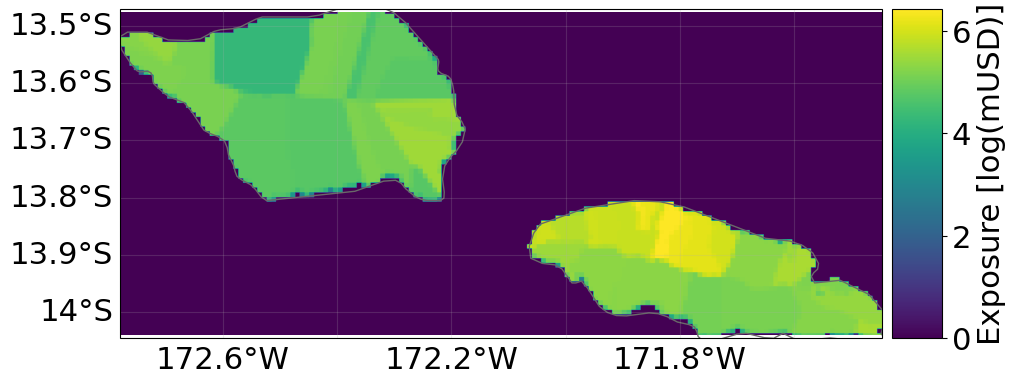

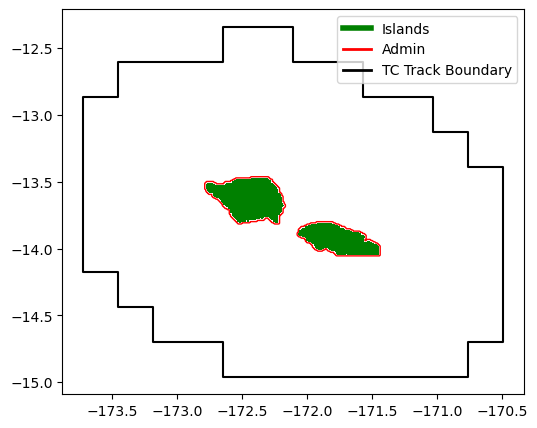

Number of tracks in SP basin: 713


In [5]:
exp, applicable_basins, grid_gdf, admin_gdf, storm_basin_sub, tc_storms = ex.init_TC_exp(country, buffer_distance_km=105, res_exp=30, grid_size=6000, buffer_grid_size=1, load_fls=True)

In [6]:
#plot filtered tc hazards
#ax_sub = storm_basin_sub.plot()
#ax_sub.get_legend()._loc = 3

### Calculate Impact
1. Calculate impact matrix
2. Determine exposure points per grid cell
3. Calculate total impacts per grid cell and event

c:\Users\kaibe\Documents\ETH_Zurich\Thesis\Code\impact.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


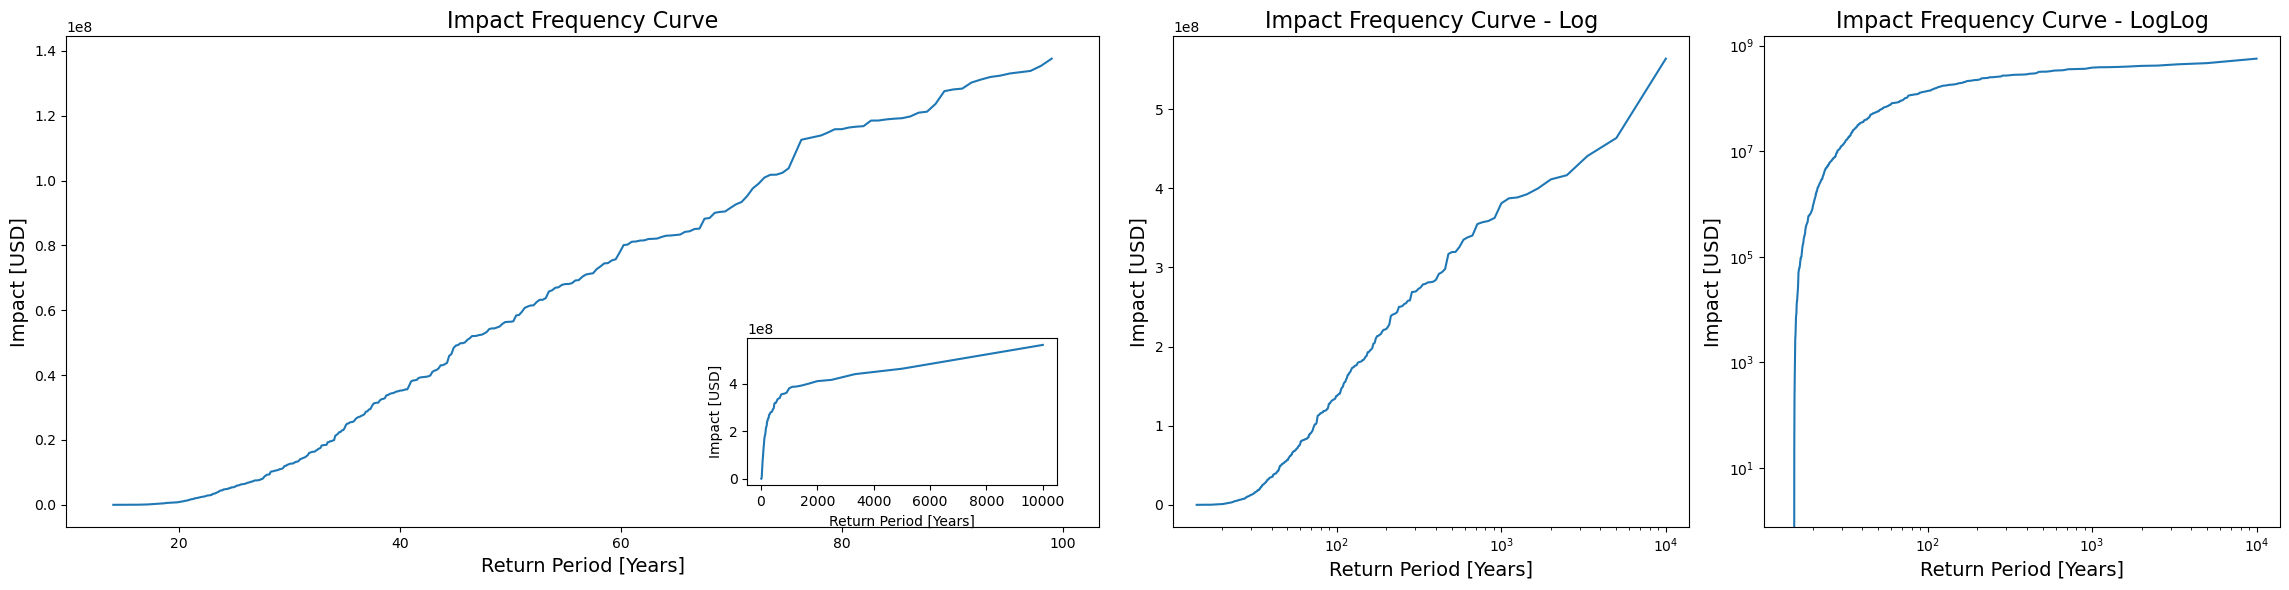

In [7]:
imp, imp_per_event, imp_admin_evt = cimp.init_imp(exp, tc_storms, admin_gdf) 
imp_per_event_flt, imp_admin_evt_flt, to_protect = bpd.init_imp_flt(imp_per_event, imp_admin_evt, prot_share=lower_share, exposure=exp)

## Optimize insurance policies

### Asses hazard intensity per event and grid cell
1. Creation of data frame which indicates the sustained wind speed per event and grid cell caclualted using a quantile or the mean across hazard centroid located in each grid cell.
2. Add year for each event.

In [8]:
int_grid = hig.init_haz_int(grid_gdf, admin_gdf, tc_storms=tc_storms, stat=90) #tc_tracks=storm_basin_sub.........tc_storms=tc_storms

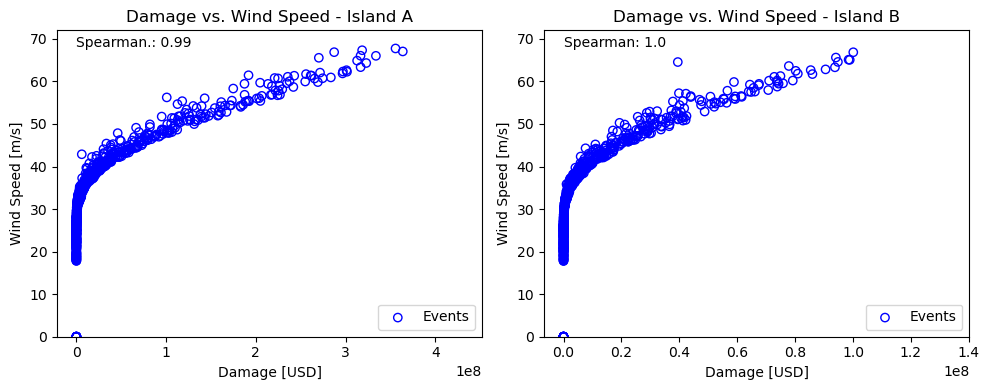

In [9]:
from scipy.stats import spearmanr

corr_a, pval = spearmanr(imp_admin_evt['A'], int_grid['A'])
corr_b, pval = spearmanr(imp_admin_evt['B'], int_grid['B'])
 
min_prot = snom.init_nominal(impact=imp, exposure=exp, prot_rp=25, print_nom=False)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.scatter(imp_admin_evt['A'], int_grid['A'], marker='o', edgecolor='blue', facecolor='none', label='Events')
# Add labels and title
ax1.set_title("Damage vs. Wind Speed - Island A")
ax1.set_xlabel("Damage [USD]")
ax1.set_ylabel("Wind Speed [m/s]")
ax1.text(0, 68, f'Spearman.: {round(corr_a, 2)}', fontsize = 10)
ax1.set_ylim(0,72)
ax1.legend(loc='lower right')
           
ax2.scatter(imp_admin_evt['B'], int_grid['B'], marker='o', edgecolor='blue', facecolor='none', label='Events')
# Add labels and title
ax2.set_title("Damage vs. Wind Speed - Island B")
ax2.set_xlabel("Damage [USD]")
ax2.set_ylabel("Wind Speed [m/s]")
ax2.text(0, 68, f'Spearman: {round(corr_b, 2)}', fontsize = 10)
ax2.set_ylim(0,72)
ax2.legend(loc='lower right')
# Show both plots
plt.tight_layout()
plt.show()


#### Set the nominal
Can be set in diferent ways:
1. Protecting a specified percentage of e.g. GDP
2. Protecting damages of specified return period

In [10]:
#define nominal
nominal = snom.init_nominal(impact=imp, exposure=exp, prot_rp=10000)

The principal of the cat bond is: 564001615.124 [USD]
Principal as share of GDP: 0.649


### Perform optimization
Optmizie payout function using linear payout inbetween a minimung triggering and a maximum wind speed. Wind speeds equal or higher than maximum wind speed result in the payout of the full principle. <br>
Wind speeds are optimized for each grid cell.

In [11]:
result, optimized_step1, optimized_step2 = apo.init_alt_optimization(int_grid, nominal, damages_grid=imp_admin_evt_flt, damages_evt=imp_per_event_flt)

{0: (39.8428468081421, 76.5315608936917), 1: (40.64795569483786, 78.45549929227663)}


### Assess payout vs damage for each event
1. Create a payout vs damage matrix per event
2. Plot payout vs damage on 1:1 scale

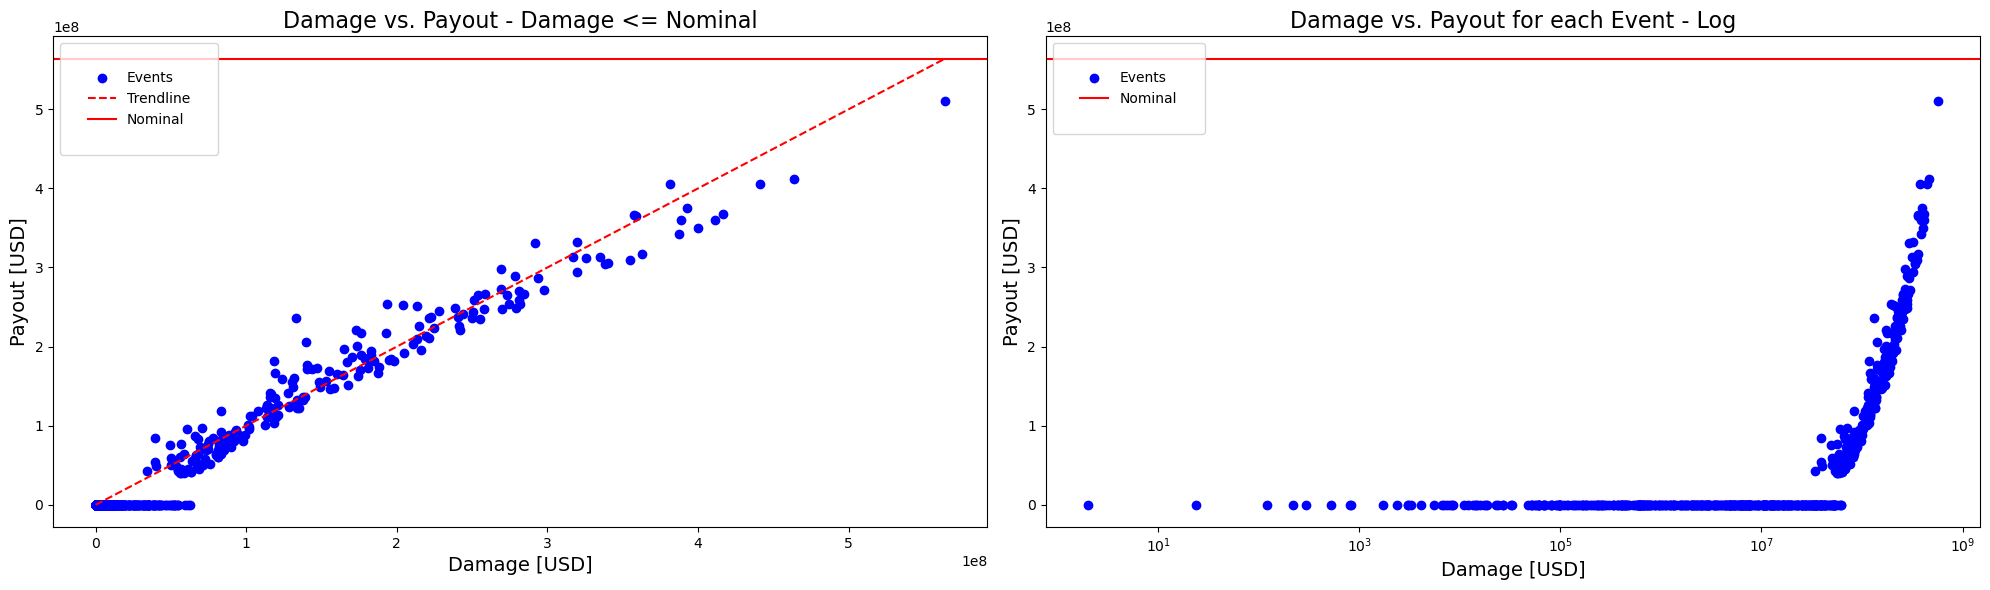

In [12]:
pay_dam_df = apo.alt_pay_vs_damage(imp_per_event_flt, optimized_step1, optimized_step2, int_grid, nominal, imp_admin_evt, imp_per_event)

In [13]:
corr, pval = spearmanr(pay_dam_df['pay'], pay_dam_df['damage'])
 
# print the result
print("Spearman's correlation coefficient:", corr)

Spearman's correlation coefficient: 0.9548724915930024


### Calculate expected loss and attachment probability
1. Set annual probaility for hazard event
2. Simulate cat bond and calculate the expected loss as well as the annual attachment probability.

In [14]:
exp_loss_ann, att_prob, ann_losses, es_metrics = sb.init_exp_loss_att_prob_simulation(pay_dam_df, nominal)

Expected Loss = 0.006021740363772132
Attachment Probability = 0.02100630189056717


### Calculate premiums using:
1. IBRD multiplier model
2. Most recent artemis multiplier
3. Linear regression model of Chatoro et al. 2022

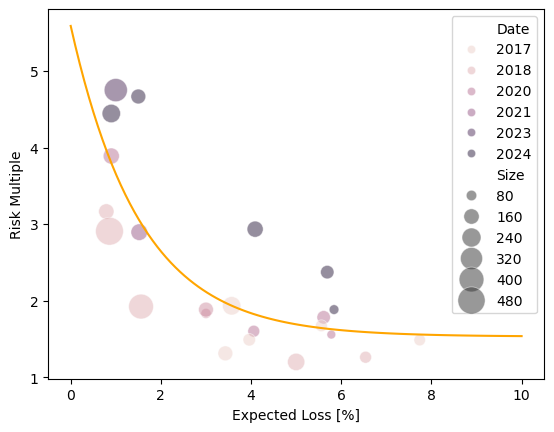

The premium based on past IBRD bonds is 2.577%, 14537075.0USD, 1.673%
The premium based on the artemis multiplier is 2.475%, 13958675.0USD, 1.606%
The premium based on the regression model from Chatoro et al. 2022 is 5.131%, 28940274.0USD, 3.331%
The premium based on required sharpe ration of 0.5 is 3.08%, 17371083.0USD, 1.999%


In [15]:
params_ibrd = prib.init_prem_ibrd()
a, k, b = params_ibrd
artemis_multiplier = 4.11
tot_exp = exp.gdf['value'].sum()

premium_ibrd = prib.monoExp(exp_loss_ann*100, a, k, b) * exp_loss_ann
premium_artemis = exp_loss_ann * artemis_multiplier
premium_regression = cp.calc_premium_regression(exp_loss_ann *100)/100
premium_sharpe = sb.init_prem_sharpe_ratio(ann_losses, rf_rate, target_sharpe)

print(f'The premium based on past IBRD bonds is {round(premium_ibrd*100, 3)}%, {round(premium_ibrd*nominal,0)}USD, {round(premium_ibrd*nominal/tot_exp*100,3)}%')
print(f'The premium based on the artemis multiplier is {round(premium_artemis*100, 3)}%, {round(premium_artemis*nominal,0)}USD, {round(premium_artemis*nominal/tot_exp*100,3)}%')
print(f'The premium based on the regression model from Chatoro et al. 2022 is {round(premium_regression*100, 3)}%, {round(premium_regression*nominal,0)}USD, {round(premium_regression*nominal/tot_exp*100,3)}%')
print(f'The premium based on required sharpe ration of {target_sharpe} is {round(premium_sharpe*100, 3)}%, {round(premium_sharpe*nominal,0)}USD, {round(premium_sharpe*nominal/tot_exp*100,3)}%')

### Calculate cat bond metrics
1. Perform Monte-Carlo Simulation
2. Calculate Metrics
    - Expected Loss
    - Attachment Probability
    - Value at risk
    - Coverage
    - Basis-Risk
    - Expected Shortfall

### Simulate a 3-year cat bond

In [ ]:
#requ_prem = sb.init_prem_sharpe_ratio(ann_losses, rf_rate, target_sharpe)
bond_metrics_sng, returns_sng = sb.init_bond_simulation(pay_dam_df, premium_ibrd, rf_rate, nominal) 
print('Return: ',np.mean(returns_sng['Annual'][0]))
print('Std: ',np.std(returns_sng['Annual'][0]))
print(returns_sng['Annual'][0][returns_sng['Annual'][0] < returns_sng['Annual'][0].quantile(0.99)].mean())

Return:  0.01948731773418923
Std:  0.0487357711747855
-0.055540477583459785


## Assess Impact of Climate Change

In [17]:
#bond_metrics_cc, bond_returns_cc, premium_dic_cc, nominal_cc, pay_dam_df_cc, es_metrics_cc, int_grid_cc, imp_per_event_flt_cc, imp_admin_evt_flt_cc = bond_create.sng_cty_bond_cc(country, 'CMCC', upper_rp, rf_rate, target_sharpe, 105, 30, to_prot_share=lower_share)

## Perform cat bond simulation using different nominals

In [18]:
#define nominals
prot_share_arr = np.arange(0.05, 0.61, 0.05) #protected share of total exposure
arr_nominal = []

for prot_share in prot_share_arr:
    nominal = snom.init_nominal(impact=imp, exposure=exp, prot_share=prot_share, print_nom=False)
    arr_nominal.append(nominal)

print('Nominals calculated')

#optimize payout per grid for each nominal
optimized_xs_nom = {}
optimized_ys_nom = {}
result_nom = {}
pay_dam_df_nom = {}
exp_loss_ann_nom = {}
att_prob_nom = {}
premium_ibrd = {}
premium_artemis = {}
premium_regression = {}
premium_simulation = {}
returns = {}
premium_simulation_ibrd = {}
returns_ibrd = {}
premium_simulation_artemis = {}
returns_artemis = {}
premium_simulation_regression = {}
returns_regression = {}
requ_premiums_mod = {}
requ_premiums_high = {}
ann_losses = {}
requ_prem =  {}

for nom in arr_nominal:
    nom_str = str(round(nom,0))
    result_nom[nom_str], optimized_xs_nom[nom_str], optimized_ys_nom[nom_str] = apo.init_alt_optimization(int_grid, nom, damages_grid=imp_admin_evt_flt, damages_evt=imp_per_event_flt, print_params=False)

    pay_dam_df_nom[nom_str] = apo.alt_pay_vs_damage(imp_per_event_flt, optimized_xs_nom[nom_str], optimized_ys_nom[nom_str], int_grid, nom, imp_admin_evt)
    
    exp_loss_ann_nom[nom_str], att_prob_nom[nom_str], ann_losses[nom_str], es_metrics[nom_str] = sb.init_exp_loss_att_prob_simulation(pay_dam_df_nom[nom_str], nom, print_prob=False)

    premium_ibrd[nom_str] = prib.monoExp(exp_loss_ann_nom[nom_str] * 100, a, k, b) * exp_loss_ann_nom[nom_str]
    premium_artemis[nom_str] = exp_loss_ann_nom[nom_str] * artemis_multiplier
    premium_regression[nom_str] = cp.calc_premium_regression(exp_loss_ann_nom[nom_str] * 100) / 100
    
    premium_simulation_ibrd[nom_str], returns_ibrd[nom_str] = sb.init_bond_simulation(pay_dam_df_nom[nom_str], premium_ibrd[nom_str], rf_rate, nom) 
    premium_simulation_artemis[nom_str], returns_artemis[nom_str] = sb.init_bond_simulation(pay_dam_df_nom[nom_str], premium_artemis[nom_str], rf_rate, nom) 
    premium_simulation_regression[nom_str], returns_regression[nom_str] = sb.init_bond_simulation(pay_dam_df_nom[nom_str], premium_regression[nom_str], rf_rate, nom) 
    requ_prem[nom_str] = sb.init_prem_sharpe_ratio(ann_losses[nom_str], rf_rate, target_sharpe)
    premium_simulation[nom_str], returns[nom_str] = sb.init_bond_simulation(pay_dam_df_nom[nom_str], requ_prem[nom_str], rf_rate, nom)
    

Nominals calculated


C:\Users\kaibe\AppData\Local\Temp\ipykernel_10956\3559033391.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bond_ret_results = pd.concat([bond_ret_results, pd.DataFrame({


(0.0, 0.08819379654428229)

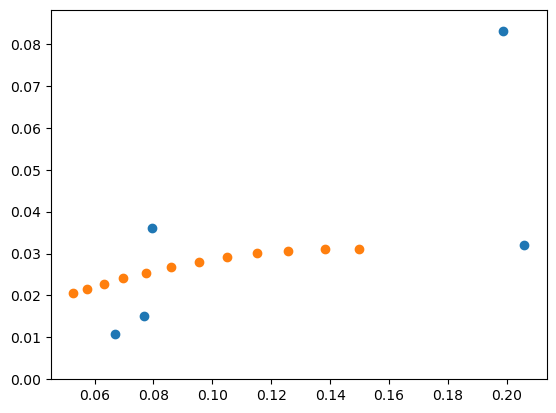

In [19]:
bond_ret_results = pd.DataFrame(columns=['Nominal', 'Return', 'Standard Deviation'])

for nom in arr_nominal:
    nom_str = str(round(nom,0))
    mean_return = np.nanmean(returns_ibrd[nom_str]['Annual'][0])
    std_risk = np.nanstd(returns_ibrd[nom_str]['Annual'][0])
    bond_ret_results = pd.concat([bond_ret_results, pd.DataFrame({
        'Nominal': [nom],
        'Return': [mean_return],
        'Standard Deviation': [std_risk]
    })], ignore_index=True)

hist_ret = pd.read_excel("C:/Users/kaibe/Documents/ETH_Zurich/Thesis/Data/Finance/hist_ret_nyu.xlsx", sheet_name='Sheet2')

summary_hist_ret_df = pd.DataFrame({
    'Return': hist_ret.mean(skipna=True),
    'Standard Deviation': hist_ret.std(skipna=True)
})

plt.scatter(summary_hist_ret_df['Standard Deviation'], summary_hist_ret_df['Return'])
plt.scatter(bond_ret_results['Standard Deviation'], bond_ret_results['Return'])
plt.ylim(0,max(summary_hist_ret_df['Return']+0.005))

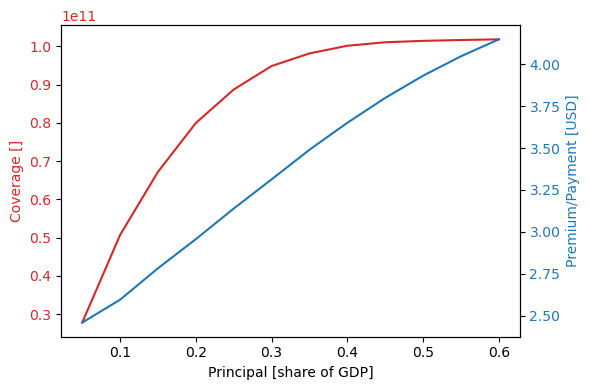

In [20]:
coverage_nom = []
basis_risk_nom = []
tot_pay_nom = []
tot_pay = []
tot_pay_gdp = []
std_nom = []
multi_pay_prem = []

for nom_it in arr_nominal:
    nom_str = str(round(nom_it,0))
    coverage_nom.append(premium_simulation_ibrd[nom_str]['Coverage'])
    tot_pay.append((premium_simulation_ibrd[nom_str]['Summed Payments']))
    multi_pay_prem.append((premium_simulation_ibrd[nom_str]['Total Premiums']/premium_simulation[nom_str]['Summed Payments']))
    tot_pay_nom.append((premium_simulation_ibrd[nom_str]['Average Payments'])/(nominal))
    tot_pay_gdp.append((premium_simulation_ibrd[nom_str]['Average Payments'])/(nominal/prot_share))
    #std = np.std(ann_losses[nom_str])
    #std_nom.append(std)

fig, ax1 = plt.subplots(figsize=(6, 4))

color = 'tab:red'
ax1.plot(prot_share_arr, tot_pay, color=color)
ax1.set_xlabel('Principal [share of GDP]')
ax1.set_ylabel('Coverage []', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Premium/Payment [USD]', color=color)  # we already handled the x-label with ax1
ax2.plot(prot_share_arr, multi_pay_prem, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()



plot premium vs coverage. How much do I need to pay for a certain coverage. Also include what a certain coverage would mean money wise for the country -> how much is paid relative to gdp

Think about other coverage metrics -> compare them.

What is good benchmark metric?

Cost-benefit with premium plot.

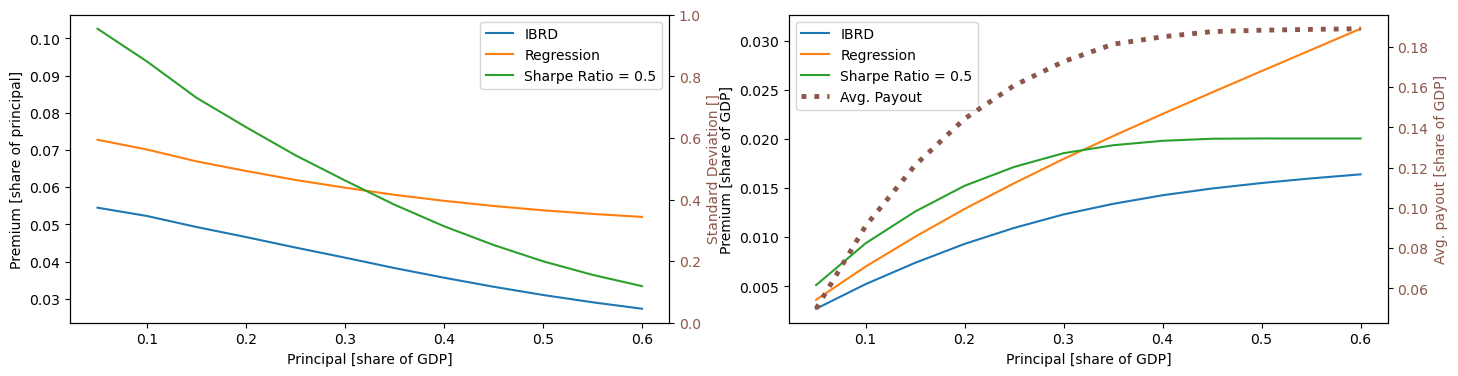

In [21]:

#requ_premiums_arr = np.array(fct.get_all_values(requ_prem))
premium_artemis_arr = np.array(fct.get_all_values(premium_artemis))
premium_ibrd_arr = np.array(fct.get_all_values(premium_ibrd))
premium_regression_arr = np.array(fct.get_all_values(premium_regression))
premium_required_arr = np.array(fct.get_all_values(requ_prem))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 4))

#ax1.plot(prot_share_arr, premium_artemis.values(), label='Artemis')
ax1.plot(prot_share_arr, premium_ibrd.values(), label='IBRD')
ax1.plot(prot_share_arr, premium_regression.values(), label='Regression')
ax1.plot(prot_share_arr, requ_prem.values(), label='Sharpe Ratio = 0.5')
ax1.set_xlabel('Principal [share of GDP]')
ax1.set_ylabel('Premium [share of principal]')
ax1.tick_params(axis='y')
#ax1.set_ylim(0,np.max(std_nom)+0.01)


ax1_1 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
color = 'tab:brown'
ax1_1.set_ylabel('Standard Deviation []', color=color)  # we already handled the x-label with ax1
#ax1_1.plot(prot_share_arr, std_nom, color=color, linewidth=3.5, linestyle='dotted', label='Std(Losses)')
ax1_1.tick_params(axis='y', labelcolor=color)
#ax1_1.set_ylim(0,np.max(std_nom)+0.01)

lines1, labels1 = ax1.get_legend_handles_labels()  
lines2, labels2 = ax1_1.get_legend_handles_labels()  
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

color = 'tab:red'
#ax2.plot(prot_share_arr, (premium_artemis_arr * arr_nominal)*3 / (nominal/prot_share), label='Artemis')
ax2.plot(prot_share_arr, (premium_ibrd_arr * arr_nominal) / (nominal/prot_share), label='IBRD')
ax2.plot(prot_share_arr, (premium_regression_arr * arr_nominal) / (nominal/prot_share), label='Regression')
ax2.plot(prot_share_arr, (premium_required_arr * arr_nominal) / (nominal/prot_share), label='Sharpe Ratio = 0.5')
ax2.set_xlabel('Principal [share of GDP]')
ax2.set_ylabel('Premium [share of GDP]')
ax2.tick_params(axis='y')

ax3 = ax2.twinx()  # instantiate a second Axes that shares the same x-axis
color = 'tab:brown'
ax3.set_ylabel('Avg. payout [share of GDP]', color=color)  # we already handled the x-label with ax1
ax3.plot(prot_share_arr, tot_pay_gdp, color=color, linewidth=3.5, linestyle='dotted', label='Avg. Payout')
ax3.tick_params(axis='y', labelcolor=color)


lines1, labels1 = ax2.get_legend_handles_labels()  
lines2, labels2 = ax3.get_legend_handles_labels()  
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.show()

What sharpe ratio do the calculated premiums imply.

Why do the curves behave like they do? -> make comments

Check on stop payment if payout happpens.

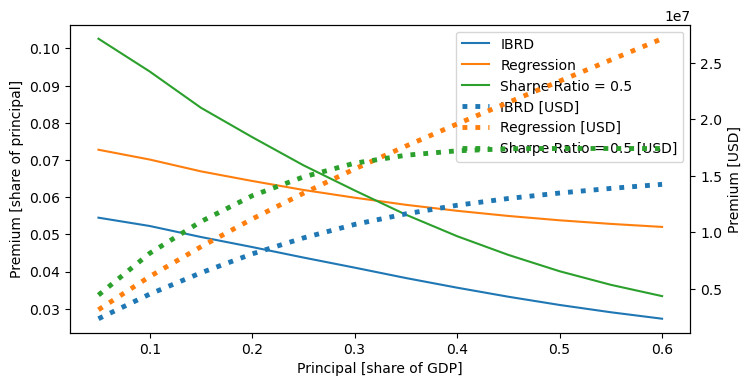

In [22]:
fig, ax1 = plt.subplots(figsize=(8, 4))

#ax1.plot(prot_share_arr, premium_artemis.values(), label='Artemis')
ax1.plot(prot_share_arr, premium_ibrd.values(), label='IBRD')
ax1.plot(prot_share_arr, premium_regression.values(), label='Regression')
ax1.plot(prot_share_arr, requ_prem.values(), label='Sharpe Ratio = 0.5')
ax1.set_xlabel('Principal [share of GDP]')
ax1.set_ylabel('Premium [share of principal]')
ax1.tick_params(axis='y')


ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
color = 'tab:brown'
ax2.set_ylabel('Premium [USD]')  # we already handled the x-label with ax1
ax2.plot(prot_share_arr, (premium_ibrd_arr * arr_nominal), label='IBRD [USD]', linewidth=3.5, linestyle='dotted')
ax2.plot(prot_share_arr, (premium_regression_arr * arr_nominal), label='Regression [USD]', linewidth=3.5, linestyle='dotted')
ax2.plot(prot_share_arr, (premium_required_arr * arr_nominal), label='Sharpe Ratio = 0.5 [USD]', linewidth=3.5, linestyle='dotted')

lines1, labels1 = ax1.get_legend_handles_labels()  
lines2, labels2 = ax2.get_legend_handles_labels()  
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

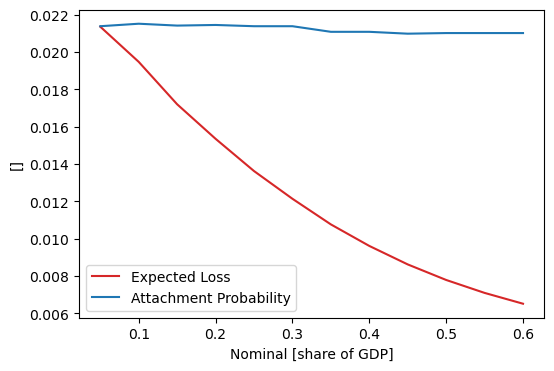

In [23]:
exp_loss_arr = np.array(fct.get_all_values(exp_loss_ann_nom))
att_prob_arr = np.array(fct.get_all_values(att_prob_nom))

fig, ax1 = plt.subplots(figsize=(6, 4))

color = 'tab:red'
ax1.plot(prot_share_arr, exp_loss_arr, color=color, label='Expected Loss')
ax1.set_xlabel('Nominal [share of GDP]')
ax1.set_ylabel('[]')

color = 'tab:blue'
ax1.plot(prot_share_arr, att_prob_arr, color=color, label='Attachment Probability')

plt.legend()
plt.show()

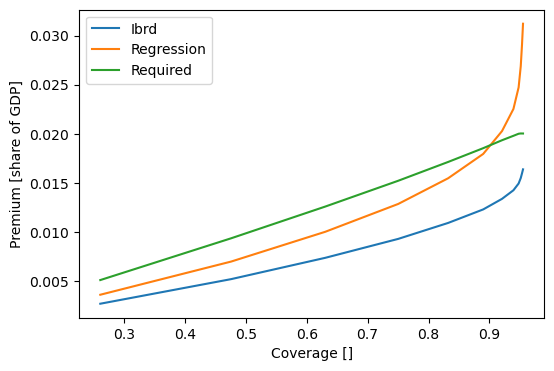

In [24]:
fig, ax1 = plt.subplots(figsize=(6, 4))

ax1.plot(coverage_nom, premium_ibrd_arr*arr_nominal/tot_exp, label='Ibrd')
ax1.plot(coverage_nom, premium_regression_arr*arr_nominal/tot_exp, label='Regression')
ax1.plot(coverage_nom, premium_required_arr*arr_nominal/tot_exp, label='Required')
ax1.set_xlabel('Coverage []')
ax1.set_ylabel('Premium [share of GDP]')


plt.legend()
plt.show()